In [1]:
import nltk
import pandas as pd
import re
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
nltk.download('punkt')
import matplotlib.pyplot as plt
import seaborn as sns

from nltk import word_tokenize,sent_tokenize
import xgboost
import numpy as np
from sklearn.model_selection import train_test_split

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Alex\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## 1. Data Cleaning

In [2]:
#df = pd.read_csv("generic_tweets.txt")
tweets = open('generic_tweets.txt','r').read()
tweetsListOriginal = tweets.split('\n')
# '"class","id","date","query","user","text"'
del tweetsListOriginal[0] #field names, header column removed
del tweetsListOriginal[-1] #Blank line removed
tweetsListOriginal[0:5]

['"0","1467810369","Mon Apr 06 22:19:45 PDT 2009","NO_QUERY","_TheSpecialOne_","@switchfoot http://twitpic.com/2y1zl - Awww, that\'s a bummer.  You shoulda got David Carr of Third Day to do it. ;D"',
 '"0","1467810672","Mon Apr 06 22:19:49 PDT 2009","NO_QUERY","scotthamilton","is upset that he can\'t update his Facebook by texting it... and might cry as a result  School today also. Blah!"',
 '"0","1467810917","Mon Apr 06 22:19:53 PDT 2009","NO_QUERY","mattycus","@Kenichan I dived many times for the ball. Managed to save 50%  The rest go out of bounds"',
 '"0","1467811184","Mon Apr 06 22:19:57 PDT 2009","NO_QUERY","ElleCTF","my whole body feels itchy and like its on fire "',
 '"0","1467811193","Mon Apr 06 22:19:57 PDT 2009","NO_QUERY","Karoli","@nationwideclass no, it\'s not behaving at all. i\'m mad. why am i here? because I can\'t see you all over there. "']

In [3]:
#Remove everything but the text, remove fields before first five commas
tweetsList = [tweet.split(',')[5:] for tweet in tweetsListOriginal]
tweetsList = [' '.join(tweet) for tweet in tweetsList]
tweetsList[0:5]

['"@switchfoot http://twitpic.com/2y1zl - Awww  that\'s a bummer.  You shoulda got David Carr of Third Day to do it. ;D"',
 '"is upset that he can\'t update his Facebook by texting it... and might cry as a result  School today also. Blah!"',
 '"@Kenichan I dived many times for the ball. Managed to save 50%  The rest go out of bounds"',
 '"my whole body feels itchy and like its on fire "',
 '"@nationwideclass no  it\'s not behaving at all. i\'m mad. why am i here? because I can\'t see you all over there. "']

In [4]:
# Remove all html tags and attributes
# <       - a left tag
# [^>] - anything but a right tag...
# +       - ...one or more times
# >       - a right tag.
print(tweetsList[8315])
tweetsList = [tweet.replace('&lt;', '<').replace("&gt;",">").replace("&quot;",'"').replace("&amp;","&") for tweet in tweetsList]
tweetsList = [re.sub('<[^<]+?>', '', x) for x in tweetsList]
#Check
print(tweetsList[8315])

"I never made &lt;a href=&quot;http://www.apple.com/downloads/dashboard/music/redalarmclock.html&quot;&gt;Red Alarm Clock&lt;/a&gt; work "
"I never made Red Alarm Clock work "


In [5]:
#Html character codes (i.e., &...;) are replaced with an ASCII equivalent
tweetsList = [x.encode('unicode-escape').decode('ascii') for x in tweetsList]

In [6]:
# All URLs are removed.
print(tweetsList[0])
tweetsList = [re.sub('http\S+', '', x) for x in tweetsList]
#check
print(tweetsList[0])

"@switchfoot http://twitpic.com/2y1zl - Awww  that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D"
"@switchfoot  - Awww  that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D"


In [7]:
#All lowercase
tweetsList = [x.lower() for x in tweetsList]
tweetsList = [x.replace("\\'","'") for x in tweetsList]
#check
print(tweetsList[0:5])

['"@switchfoot  - awww  that\'s a bummer.  you shoulda got david carr of third day to do it. ;d"', '"is upset that he can\'t update his facebook by texting it... and might cry as a result  school today also. blah!"', '"@kenichan i dived many times for the ball. managed to save 50%  the rest go out of bounds"', '"my whole body feels itchy and like its on fire "', '"@nationwideclass no  it\'s not behaving at all. i\'m mad. why am i here? because i can\'t see you all over there. "']


Words inside stopwords.txt are considered stop words to be removed

In [8]:
# Also did stemming even though assignment doesn't specify it
tweetsListClean = []
#cachedStopWords = stopwords.words("english")
stopWords = open('stop_words.txt','r').read()
stopWords = stopWords.split('\n')
#Remove everything not alpha numeric
tweetsList = [re.sub('[^A-Za-z0-9 ]+', '', x) for x in tweetsList]
for tweet in tweetsList:
    tokenizer = RegexpTokenizer(r'\w+')   
    #b = tokenizer.tokenize(tweet) # removes punctuation
    #words_rmStop = [word for word in b if word not in stopWords]
    words_rmStop = [word for word in tweet.split() if word not in stopWords]
    ps = PorterStemmer() 
    words_stem = [ps.stem(word) for word in words_rmStop] # stem 
    #tweetsListClean.append(' '.join(words_rmStop))
    tweetsListClean.append(' '.join(words_stem))

#check
tweetsListClean[0:5]

['switchfoot awww bummer shoulda david carr third day',
 'upset cant updat facebook text cri result school today blah',
 'kenichan dive time ball manag save 50 rest bound',
 'bodi feel itchi fire',
 'nationwideclass behav mad cant']

Note: Still some issues with contractions (cant, didnt) not being removed, potential future work.

## 2. Exploratory Analysis

### Apply  data cleaning rules to election tweets

In [9]:
#pol_tweets = pd.read_csv("Canadian_elections_2019.csv")
pol_tweets = open('Canadian_elections_2019.csv','r').read()
pol_tweetsListOriginal = pol_tweets.split('\n')
# sentiment,negative_reason,text
del pol_tweetsListOriginal[0] #field names, header column removed
del pol_tweetsListOriginal[-1] #Blank line removed
pol_tweetsListOriginal[0:2]

['negative,Women Reproductive right and Racism,"b""@RosieBarton So instead of your suggestion, how about we agree that #Canadian #women can not and should not trust that #AndrewScheer and a #Conservatives government will protect a woman\'s right to have automony over her body. Let\'s go with that.  #cdnpoli #elxn43  #Canada #abortion"""',
 'positive,,"b""#AllWomanSpacewalk it\'s real!\\n@Space_Station \\n#EtobicokeNorth #CityofTO #ONPoli #cdnpoli #elxn43 https://t.co/wgdXLksTbQ"""']

In [10]:
#Remove everything but the text, remove fields before first two commas
pol_tweetsList = [tweet.split(',')[2:] for tweet in pol_tweetsListOriginal]
pol_tweetsList = [' '.join(tweet) for tweet in pol_tweetsList]
pol_tweetsList[0:2]

['"b""@RosieBarton So instead of your suggestion  how about we agree that #Canadian #women can not and should not trust that #AndrewScheer and a #Conservatives government will protect a woman\'s right to have automony over her body. Let\'s go with that.  #cdnpoli #elxn43  #Canada #abortion"""',
 '"b""#AllWomanSpacewalk it\'s real!\\n@Space_Station \\n#EtobicokeNorth #CityofTO #ONPoli #cdnpoli #elxn43 https://t.co/wgdXLksTbQ"""']

In [11]:
#Remove \n, "b"", '"""' in each tweet
pol_tweetsList = [tweet.replace('\\n',' ').replace('"b""','').replace('"""','') for tweet in pol_tweetsList]
pol_tweetsList[0:2]

["@RosieBarton So instead of your suggestion  how about we agree that #Canadian #women can not and should not trust that #AndrewScheer and a #Conservatives government will protect a woman's right to have automony over her body. Let's go with that.  #cdnpoli #elxn43  #Canada #abortion",
 "#AllWomanSpacewalk it's real! @Space_Station  #EtobicokeNorth #CityofTO #ONPoli #cdnpoli #elxn43 https://t.co/wgdXLksTbQ"]

In [12]:
#Can't fix slashes with emoji
# Canada emoji: \xf0\x9f\x98\xa0
#pol_tweetsList = [x.replace("\x",'x') for x in pol_tweetsList]
pol_tweetsList[9]

"#CPCKinsellaGate Let's see the receipts. Who pays Warren Kinsella to make up sleaze? #cdnpoli #elxn43  #VoteLiberal \\xf0\\x9f\\x87\\xa8\\xf0\\x9f\\x87\\xa6 #ChooseForward https://t.co/34ltshteve"

In [13]:
# Remove all html tags and attributes and replace linkbreaks \n with spaces
pol_tweetsList = [tweet.replace('&lt;', '<').replace("&gt;",">").replace("&quot;",'"').replace("&amp;","&") for tweet in pol_tweetsList]
pol_tweetsList = [re.sub('<[^<]+?>', '', x) for x in pol_tweetsList]
pol_tweetsList[9]

"#CPCKinsellaGate Let's see the receipts. Who pays Warren Kinsella to make up sleaze? #cdnpoli #elxn43  #VoteLiberal \\xf0\\x9f\\x87\\xa8\\xf0\\x9f\\x87\\xa6 #ChooseForward https://t.co/34ltshteve"

In [14]:
# All URLs are removed.
print(pol_tweetsList[1])
pol_tweetsList = [re.sub('http\S+', '', x) for x in pol_tweetsList]
#check
print(pol_tweetsList[1])

#AllWomanSpacewalk it's real! @Space_Station  #EtobicokeNorth #CityofTO #ONPoli #cdnpoli #elxn43 https://t.co/wgdXLksTbQ
#AllWomanSpacewalk it's real! @Space_Station  #EtobicokeNorth #CityofTO #ONPoli #cdnpoli #elxn43 


In [15]:
#Html character codes (i.e., &...;) are replaced with an ASCII equivalent
pol_tweetsList = [x.encode('unicode-escape').decode('ascii') for x in pol_tweetsList]

In [16]:
#All lowercase
pol_tweetsList = [x.lower() for x in pol_tweetsList]
pol_tweetsList = [x.replace("\\'","'") for x in pol_tweetsList]
#check
print(pol_tweetsList[0:2])

["@rosiebarton so instead of your suggestion  how about we agree that #canadian #women can not and should not trust that #andrewscheer and a #conservatives government will protect a woman's right to have automony over her body. let's go with that.  #cdnpoli #elxn43  #canada #abortion", "#allwomanspacewalk it's real! @space_station  #etobicokenorth #cityofto #onpoli #cdnpoli #elxn43 "]


Words inside stopwords.txt as well as common words like 'canad', 'vot' and common hashtags: #election2019 #elxn43 #cdnpoli are all considered stop words to be removed

In [17]:
# Also did stemming even though assignment doesn't specify it
pol_tweetsListClean = []
stopWords = open('stop_words.txt','r').read()
stopWords = stopWords.split('\n')
commonWords = ['canada','vote','votes','voting','canadian','election','country','canadians','prime','minister','pm','campaign']
commonHashtags = ['canadaelection2019','canadavotes','canadavotes2019','election2019', 'elxn43', 'cdnpoli','vote2019',
                  'electionscanada','electionscan','elxn2019']
stopWords = stopWords + commonHashtags + commonWords
#Remove everything not alpha numeric
pol_tweetsList = [re.sub('[^A-Za-z0-9 ]+', '', x) for x in pol_tweetsList]
for tweet in pol_tweetsList:
    tokenizer = RegexpTokenizer(r'\w+')   
    words_rmStop = [word for word in tweet.split() if word not in stopWords]
    ps = PorterStemmer() 
    words_stem = [ps.stem(word) for word in words_rmStop] # stem 
    pol_tweetsListClean.append(' '.join(words_stem))
#check
pol_tweetsListClean[0:10]

['rosiebarton suggest agre women trust andrewsch conserv govern will protect woman automoni bodi abort',
 'allwomanspacewalk real spacest etobicokenorth cityofto onpoli',
 'brantford go cost 94 billion 4 year justin',
 'cant decid help',
 'taxpay sick tire hard earn donat corpor welfar bum dont reason trudeaumustgo snclavalin leav care sheilacopp snclavalinscand',
 'fact blastfromthepast 2012 conserv introduc longgun registri head polic victim group object crime control public safeti gunlobbi',
 'cdnmedia ppc rocki dong hand best video googl rocki dong box social havent rocki',
 'liber doubl promis 2015 nation debt term reelect forecast 90 billion wout nation pharmacar program incl wout ndp coalit 180 billion imo',
 'chooseforward dont america mistak full frontal tb youtub',
 'cpckinsellag receipt pay warren kinsella sleaz voteliber xf0x9fx87xa8xf0x9fx87xa6 chooseforward']

### Predicting each tweet's political party (Liberal, Conservative, NDP, None)

Most hashtags and mentions a contain key word phrase, for example "#TrudeauMustGo" contains trudeau, "#ScheerLies" and @AndrewScheer contains scheer, "#UpRiSingh" contains "singh". Only certain ones like "#BigBlueWave" are kept intact and lowercased. 

Omitted "Lib' and "Con' because these two shortforms are also shortforms for many other words like 'contest'.

Also black face and blackface are used, so I opted to use 'face'. Similarly for '#SNCLavalin' or "SNC Lavalin", i just used 'snc'.

Also if there is a tiebreaker between counts of words, then choose liberal, conservative, ndp in that ranking.

In [18]:
#Many hashtags contain these words
liberal_list = ['lpc','libera','justin','trude','snc','lav','face','chooseforward']
conservative_list = ['conserv','andre','schee','ford','cpc','harper', 'tory', 'tories','bigbluewave']
ndp_list = ['new','democrat','ndp','jagmeet','singh','layton','mulcair','orange']

from collections import Counter
#For each tweet, count how many words from each party's list they contain.
#if sum of word counts is 0, then classify it as none
array_party = np.array
for pol_tweet in pol_tweetsListClean:
    lib_count = 0
    con_count = 0
    ndp_count = 0
    for keyword in liberal_list:
        if keyword in pol_tweet:
            lib_count += pol_tweet.count(keyword)
    for keyword in conservative_list:
        if keyword in pol_tweet:
            con_count += pol_tweet.count(keyword)
    for keyword in ndp_list:
        if keyword in pol_tweet:
            ndp_count += pol_tweet.count(keyword)
    
    if lib_count + con_count + ndp_count == 0:
         array_party = np.append(array_party,'none')
    elif lib_count >= con_count and lib_count >= ndp_count:
        array_party = np.append(array_party,'liberal')
    elif con_count >= lib_count and con_count >= ndp_count:
        array_party = np.append(array_party,'conservative')
    else:
        array_party = np.append(array_party,'ndp')
#drop first element <built-in function array>
array_party = array_party[1:]
print(array_party[0:2])
print(array_party.shape)

['conservative' 'none']
(2133,)


(array(['conservative', 'liberal', 'ndp', 'none'], dtype=object),
 array([564, 503, 269, 797], dtype=int64))

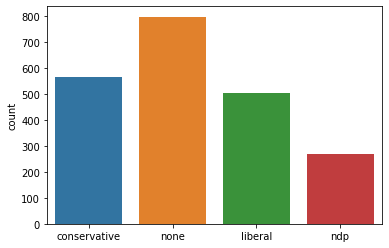

In [19]:
# Distribution of political tweets
sns.countplot(array_party)
np.unique(array_party,return_counts=True)

From the graph above, there were more tweets about conservatives than the other two parties. Meaning that most people are critical of the conservatives, considering they lost. Since, twitter demographics skew to a younger crowd and the conservatives want to cut education, spending and don't believe that in gay rights or abortion that conflicts with the values of the younger population (who have debt, support LGBT).

Also an even larger proportion aren't mentioning these 3 parties but rather just stating to go out and vote or talking about the other parties: People's Party, Green, Bloc Quebecois.

Overall, we can't determine if these tweets are supporting or criticizing each party, nor can we draw conclusions on who the person who made the tweet will vote for without considering sentiment as well.

### Generic Tweets and Election Tweets Word Clouds

As expected, the generic tweets use common internet slang: 'lol', complaining about 'work', feeling 'love'.

While the political tweets mention candidates 'scheer', 'trudeau', also 'lies' from the #ScheerLies, 'will' meaning if a candidate is elected what will they do, 'chooseforward' is from the Liberal's slogan.

In [20]:
import PIL.Image
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
import random 
from random import randint
from wordcloud import WordCloud
from wordcloud import ImageColorGenerator

In [21]:
def bcolor(word, font_size, position, orientation, random_state=None, **kwargs):
    return cv.format(random.randint(180, 210), random.randint(40, 60))

def rcolor(word, font_size, position, orientation, random_state=None, **kwargs):
    return cv.format(random.randint(0, 50), random.randint(40, 60))

In [22]:
gen_tweets_df=pd.DataFrame(data=tweetsListClean,columns=['tweet'])
gen_tweets_text= ','.join(gen_tweets_df.tweet)

pol_tweets_df=pd.DataFrame(data=pol_tweetsListClean,columns=['tweet'])
pol_tweets_text= ','.join(pol_tweets_df.tweet)

cv = 'hsl({:d}, 60%, {:d}%)'

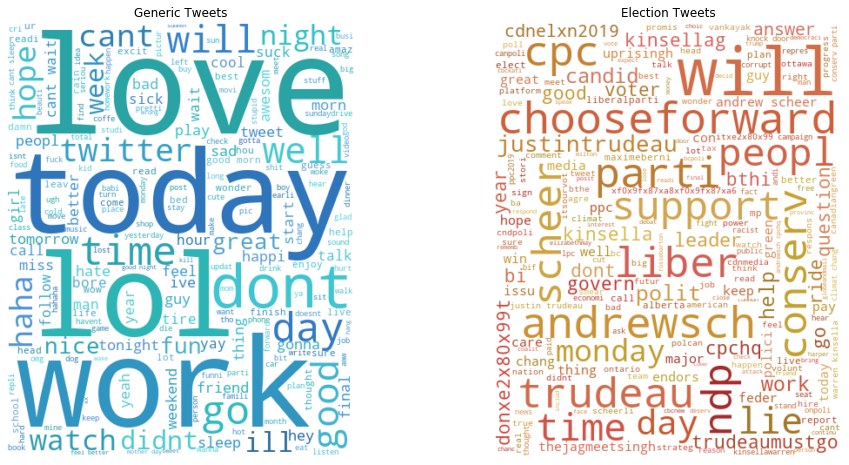

In [23]:
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=[16,8])

wordcloud1 = WordCloud(background_color='white', height=500).generate(gen_tweets_text)
ax1.imshow(wordcloud1.recolor(color_func=bcolor, random_state=3),interpolation="bilinear")
ax1.axis('off');
ax1.set_title('Generic Tweets');

wordcloud2 = WordCloud(background_color='white', height=500).generate(pol_tweets_text)
ax2.imshow(wordcloud2.recolor(color_func=rcolor, random_state=3),interpolation="bilinear")
ax2.axis('off');
ax2.set_title('Election Tweets');

## 3. Model Preparation

In [24]:
#Extract generic tweet labels, 0 = negative emotion, 4 = positive emotion
labelsList = [int(tweet.split(',')[0].replace('"','')) for tweet in tweetsListOriginal]
print(labelsList[199999])
array_labels = np.asarray(labelsList)
print(array_labels.shape)

4
(200000,)


#### Generic Tweets - Bag of Words (Word Frequency) Features

In [25]:
# https://machinelearningmastery.com/prepare-text-data-machine-learning-scikit-learn/
# create the transform
vectorizer = CountVectorizer(max_features=5000) #Only keep 5,000 most frequent words
array_WF = vectorizer.fit_transform(tweetsListClean).toarray()
#print(vectorizer.get_feature_names())
#print(array_WF)
print(array_WF.shape)
#70/30 Train/Test Split
X_train_WF, X_test_WF, y_train_WF, y_test_WF = train_test_split(array_WF, array_labels, test_size=0.3, random_state=42)

(200000, 5000)


In [212]:
X_train_WF.shape
y_train_WF.shape

(140000,)

#### Generic Tweets - TF-IDF Features

In [140]:
vectorizer2 = TfidfVectorizer(use_idf=False, norm="l1",max_features=5000)
array_TF1 = vectorizer2.fit_transform(tweetsListClean).toarray()
#print(vectorizer2.get_feature_names())
#print(array_TF1)
print(array_TF1.shape)

#70/30 Train/Test Split
X_train_TF, X_test_TF, y_train_TF, y_test_TF = train_test_split(array_TF1, array_labels, test_size=0.3, random_state=42)

(200000, 5000)


## 4. Model Implementation

Two cells for each algorithmn.
1. Generic tweets - word frequency
2. Generic tweets - tf-idf

#### Logistic Regression

In [23]:
%%time
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(random_state=0, tol=1e-4)
clf.fit(X_train_WF, y_train_WF)  
clf.score(X_test_WF, y_test_WF)

C:\Users\Alex\Anaconda3\envs\mie451-1513\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Wall time: 58.6 s
Parser   : 395 ms


0.7358833333333333

In [24]:
clf = LogisticRegression(random_state=0, tol=1e-4)
clf.fit(X_train_TF, y_train_TF)  
clf.score(X_test_TF, y_test_TF)

C:\Users\Alex\Anaconda3\envs\mie451-1513\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.7336166666666667

#### k-NN - takes too long to run in final submission so commented out, it did not out-perform Logistic Regression whe when 

%%time
from sklearn.neighbors import KNeighborsClassifier
clf = KNeighborsClassifier(n_jobs = -1)
clf.fit(X_train_WF, y_train_WF)
clf.score(X_test_WF, y_test_WF)

clf = KNeighborsClassifier(n_jobs = -1)
clf.fit(X_train_TF, y_train_TF)
clf.score(X_test_TF, y_test_TF)

#### Naive Bayes - Multinomial for WF since discrete, Gaussian for TF since continuous

In [25]:
%%time
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB()
clf.fit(X_train_WF, y_train_WF)
clf.score(X_test_WF, y_test_WF)

Wall time: 43.7 s


0.7274333333333334

In [26]:
from sklearn.naive_bayes import GaussianNB
clf = GaussianNB()
clf.fit(X_train_TF, y_train_TF)
clf.score(X_test_TF, y_test_TF)

0.6496333333333333

#### SVM

In [27]:
%%time
from sklearn.svm import LinearSVC
clf = LinearSVC(random_state=0, tol=1e-4)
clf.fit(X_train_WF, y_train_WF)  
clf.score(X_test_WF, y_test_WF)

C:\Users\Alex\Anaconda3\envs\mie451-1513\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Wall time: 1min 56s


0.73355

In [28]:
clf = LinearSVC(random_state=0, tol=1e-4)
clf.fit(X_train_TF, y_train_TF)  
clf.score(X_test_TF, y_test_TF)

0.7327833333333333

#### Decision Trees

In [29]:
%%time
from sklearn import tree
clf = tree.DecisionTreeClassifier(random_state=0,max_depth=10,max_features=0.5)
clf.fit(X_train_WF, y_train_WF)  
clf.score(X_test_WF, y_test_WF)

Wall time: 2min 37s
Parser   : 214 ms


0.5842333333333334

In [30]:
clf = tree.DecisionTreeClassifier(random_state=0,max_depth=10,max_features=0.5)
clf.fit(X_train_TF, y_train_TF)  
clf.score(X_test_TF, y_test_TF)

0.5913833333333334

#### Random Forest

In [31]:
%%time
#https://stackoverflow.com/questions/20463281/how-do-i-solve-overfitting-in-random-forest-of-python-sklearn
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators = 10,random_state=0,max_depth=10,max_features=0.5)
clf.fit(X_train_WF, y_train_WF)  
clf.score(X_test_WF, y_test_WF)

Wall time: 12min 12s
Parser   : 153 ms


0.6067

In [32]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=10, random_state=0,max_depth=10,max_features=0.5)
clf.fit(X_train_TF, y_train_TF)  
clf.score(X_test_TF, y_test_TF)

0.6021

#### XG Boost

In [33]:
%%time
#https://xgboost.readthedocs.io/en/latest/python/python_api.html
from xgboost import XGBClassifier
clf = XGBClassifier(n_estimators=10)
clf.fit(X_train_WF, y_train_WF,
        eval_set=[(X_test_WF, y_test_WF)],
        eval_metric='logloss',
        verbose=True)
evals_result = clf.evals_result()
evals_result 

[0]	validation_0-logloss:0.690102
[1]	validation_0-logloss:0.687582
[2]	validation_0-logloss:0.685402
[3]	validation_0-logloss:0.683307
[4]	validation_0-logloss:0.680784
[5]	validation_0-logloss:0.679183
[6]	validation_0-logloss:0.677461
[7]	validation_0-logloss:0.675988
[8]	validation_0-logloss:0.674593
[9]	validation_0-logloss:0.673127
Wall time: 33min 2s


{'validation_0': {'logloss': [0.690102,
   0.687582,
   0.685402,
   0.683307,
   0.680784,
   0.679183,
   0.677461,
   0.675988,
   0.674593,
   0.673127]}}

In [163]:
from xgboost import XGBClassifier
clf = XGBClassifier(n_estimators=10)
clf.fit(X_train_TF, y_train_TF,
        eval_set=[(X_test_TF, y_test_TF)],
        eval_metric='logloss',
        verbose=True)
evals_result = clf.evals_result()
evals_result

[0]	validation_0-logloss:0.690103
[1]	validation_0-logloss:0.687572
[2]	validation_0-logloss:0.685389
[3]	validation_0-logloss:0.683358
[4]	validation_0-logloss:0.681545
[5]	validation_0-logloss:0.67985
[6]	validation_0-logloss:0.678178
[7]	validation_0-logloss:0.676708
[8]	validation_0-logloss:0.675294
[9]	validation_0-logloss:0.673789


{'validation_0': {'logloss': [0.690103,
   0.687572,
   0.685389,
   0.683358,
   0.681545,
   0.67985,
   0.678178,
   0.676708,
   0.675294,
   0.673789]}}

### Evaluating the best model on the elections tweets data
The Logistic Regression model with word frequency count features performed the best so will evaluate this model on the election tweets data.

In [116]:
##Extract political tweet labels, recoding negative = , positive = 4 to match the generic tweets
pol_labelsList = [tweet.split(',')[0] for tweet in pol_tweetsListOriginal]
pol_labelsList = [0 if label =='negative' else 4 for label in pol_labelsList]
array_pol_labels = np.asarray(pol_labelsList)
print(array_pol_labels.shape)

(2133,)


#### Election Tweets - Bag of Words (Word Frequency) Features

In [117]:
# https://machinelearningmastery.com/prepare-text-data-machine-learning-scikit-learn/
# create the transform
vectorizer = CountVectorizer(max_features=5000) #Only keep 5,000 most frequent words
array_WF_pol = vectorizer.fit_transform(pol_tweetsListClean).toarray()
print(array_WF_pol.shape)

(2133, 5000)


In [118]:
%%time
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(random_state=0, tol=1e-4)
clf.fit(X_train_WF, y_train_WF)  
clf.score(X_test_WF, y_test_WF)

Wall time: 14.4 s


0.7358833333333333

##### The best performing model only acheives 50% accuracy when evaluated on the political tweets, which is quite sub-par.

In [33]:
clf.score(array_WF_pol, array_pol_labels)

0.5035161744022504

In [34]:
pol_predictions = clf.predict(array_WF_pol)

#### Election Tweets - Party vs. Actual Sentiment and Party vs. Predicted Sentiment

In [36]:
#Create dataframe with 3 columns: party, actual sentiment, predicted sentiment
sentiment_party_df = pd.DataFrame(data={'party':array_party,
                                        'actual_sentiment':array_pol_labels,
                                        'predict_sentiment':pol_predictions})
sentiment_party_df.head()

,party,actual_sentiment,predict_sentiment
0,conservative,0,0
1,none,4,4
2,liberal,0,4
3,none,4,4
4,liberal,0,0


Text(0.5, 1.0, 'Party vs. Actual Sentiment, 0 = Negative, 4 = Positive')

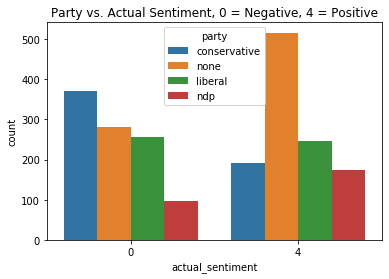

In [159]:
sns.countplot(sentiment_party_df.actual_sentiment, hue = sentiment_party_df.party).set_title("Party vs. Actual Sentiment, 0 = Negative, 4 = Positive")

Text(0.5, 1.0, 'Party vs. Predicted Sentiment, 0 = Negative, 4 = Positive')

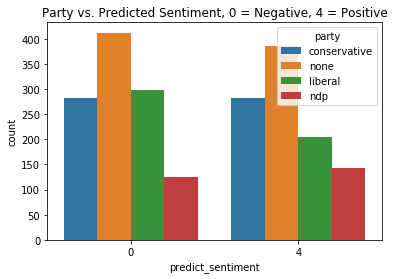

In [161]:
sns.countplot(sentiment_party_df.predict_sentiment, hue = sentiment_party_df.party).set_title("Party vs. Predicted Sentiment, 0 = Negative, 4 = Positive")

The election outcome was the Liberals won a minority government, the conservatives came second to form the official oppositon, and the NDP lost many seats from the previous election and got 3rd. The actual sentiment scores reflect this outcome, since there are many more negative sentiment tweets for the Conservatives than the Liberals. While the Liberals also have more actual positive tweets. And overall there are fewer NDP tweets which corresponds to the NDP getting fewer votes.

As for the predicted sentiment, the model poorly transfers to the political tweets and underestimates the Conservative's negative tweets(~380 actual vs. ~280 predicted) thus over-estimating the number of positive tweets the Conservatives receives. If we were to rely on the predicted sentiment, we would predict the Conservatives would win the election.

### Negative 2019 Canadian Tweets

In [242]:
##Extract negative_reason
reasons_List = [tweet.split(',')[1] for tweet in pol_tweetsListOriginal]
array_pol_reasons = np.asarray(reasons_List)
array_pol_reasons.shape

(2133,)

In [243]:
#Create dataframe with 2 columns: reason, party, as well as add the 5000 word frequency features
#Don't need actual sentiment since they are all negative
pol_negative_df = pd.DataFrame(data={'reason':array_pol_reasons,
                                     'party':array_party})
pol_negative_df = pd.concat([pol_negative_df, pd.DataFrame(array_WF_pol)], axis=1)
#Filter only the actual negative sentiment tweets
pol_negative_df = pol_negative_df[pol_negative_df['reason'] != '']
pol_negative_df.head()

,reason,party,0,1,2,3,4,5,6,7,...,4990,4991,4992,4993,4994,4995,4996,4997,4998,4999
0,Women Reproductive right and Racism,conservative,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Economy,liberal,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Economy,liberal,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,Others,conservative,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,Others,liberal,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


[Text(0, 0, 'Women Reproductive right and Racism'),
 Text(0, 0, 'Economy'),
 Text(0, 0, 'Others'),
 Text(0, 0, 'Scandal'),
 Text(0, 0, 'Tell lies'),
 Text(0, 0, 'Privilege'),
 Text(0, 0, 'Climate Problem'),
 Text(0, 0, 'Healthcare'),
 Text(0, 0, 'Separation'),
 Text(0, 0, 'Healthcare and Marijuana')]

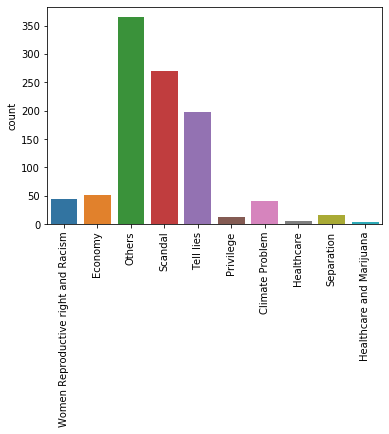

In [244]:
ax = sns.countplot(np.array(pol_negative_df.reason))
ax.set_xticklabels(ax.get_xticklabels(), rotation =90)

In [245]:
#Merge Healthcare and Marijuana into Healthcare, since similar
pol_negative_df.reason = pol_negative_df.reason.replace('Healthcare and Marijuana', 'Healthcare')

[Text(0, 0, 'Women Reproductive right and Racism'),
 Text(0, 0, 'Economy'),
 Text(0, 0, 'Others'),
 Text(0, 0, 'Scandal'),
 Text(0, 0, 'Tell lies'),
 Text(0, 0, 'Privilege'),
 Text(0, 0, 'Climate Problem'),
 Text(0, 0, 'Healthcare'),
 Text(0, 0, 'Separation')]

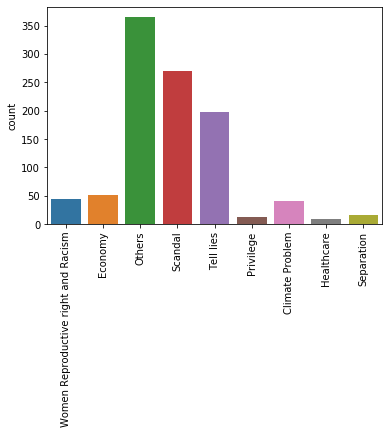

In [246]:
#Verify merge
ax = sns.countplot(np.array(pol_negative_df.reason))
ax.set_xticklabels(ax.get_xticklabels(), rotation =90)

#### 70/30 train/test split

In [247]:
#label encode reason target
from sklearn.preprocessing import LabelEncoder
nbh = LabelEncoder()
nbh_labels=nbh.fit_transform(pol_negative_df['reason'])
pol_negative_df.insert(0,'reason_Label', nbh_labels)
del pol_negative_df['reason']

#One  hot encode  the party feature
dummies_party = pd.get_dummies(pol_negative_df['party'], prefix='party')
#enc for encoded
pol_negative_df_enc =  pd.concat([pol_negative_df,dummies_party],axis=1)
pol_negative_df_enc = pol_negative_df_enc.drop(['party'],axis=1)

#First column is label
X_train_neg, X_test_neg, y_train_neg, y_test_neg = train_test_split(pol_negative_df_enc[pol_negative_df_enc.columns[1:]], pol_negative_df_enc[pol_negative_df_enc.columns[0:1]], test_size=0.3, random_state=42)

Overall, prone to overfitting since 5004 features and only 704 training samples. All three methods achieve the same performance.

In [248]:
print(y_train_neg.shape)
pol_negative_df_enc.head()

(704, 1)


,reason_Label,0,1,2,3,4,5,6,7,8,...,4994,4995,4996,4997,4998,4999,party_conservative,party_liberal,party_ndp,party_none
0,8,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
5,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
8,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


#### Logistic Regression

In [253]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(random_state=0, tol=1e-4,multi_class='ovr')
clf.fit(X_train_neg, y_train_neg)  
clf.score(X_test_neg, y_test_neg)

C:\Users\Alex\Anaconda3\envs\mie451-1513\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.5478547854785478

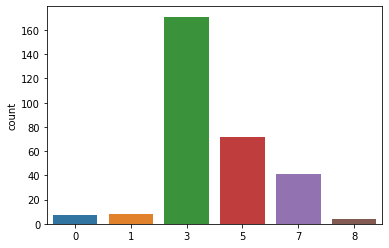

In [255]:
predictions = clf.predict(X_test_neg)
sns.countplot(predictions) #predictions only made for certain classes, not all of them although testing was small. 
# Confusion matrix would be better to evaluate where the model predictions went wrong.

#### Naive Bayes

In [250]:
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB()
clf.fit(X_train_neg, y_train_neg)  
clf.score(X_test_neg, y_test_neg)

C:\Users\Alex\Anaconda3\envs\mie451-1513\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.5478547854785478

#### SVM

In [251]:
from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier
clf = OneVsRestClassifier(SVC(kernel = 'linear',C = 1, decision_function_shape = 'ovr'))
clf.fit(X_train_neg, y_train_neg)  
clf.score(X_test_neg, y_test_neg)

0.5478547854785478

## 5. Results - What can public opinion on Twitter tell us about the Canadian political landscape in 2019?"

### First Model Discussion

The election outcome was the Liberals won a minority government, the conservatives came second to form the official oppositon, and the NDP lost many seats from the previous election and got 3rd. The actual sentiment scores in the raw data reflect this outcome, since there are many more negative sentiment tweets for the Conservatives than the Liberals. While the Liberals also have more actual positive tweets. And overall there are fewer NDP tweets which corresponds to the NDP getting fewer votes.

It's expected that there would be a higher proportion of people critical of the Conservatives since twitter demographics skew to a younger crowd and the conservatives want to cut education, OSAP, public spending, and don't believe that in gay marriage or abortion that conflicts with the values of the younger population (who have debt, support taxes, support LGBT).

As for the predicted sentiment, the model poorly transfers to the political tweets and underestimates the Conservative's negative tweets(~380 actual vs. ~280 predicted) thus over-estimating the number of positive tweets the Conservatives receives. If we were to rely on the predicted sentiment, we would predict the Conservatives would win the election which would be bad.

Therefore, to boost performance of the model I suggest:
- Training models based on actual political tweets that are not 10 years old (transfer learning from 2009 tweets doesn't work well here)
- Better cleaning to remove contractions and emojis
- Using counts of the hashtags (#TrudeauMustGo,#ChooseForward are heavily used in the test set), 
- Tune hyper parameters for random forest (max_depth, purity), 
- Deep learning and word embeddings 
- Better computer with more memory to use >5000 features

### Second Model Discussion

A few reasons for poor performance:
- Significant class imbalance, with 'Others' and 'Scandals' being the dominant reasons for negative sentiment
- Small sample sizes for most classes
- Overfitting since there are 5000+ features and only  704 training examples

To improve the accuracy of the models:
- From the test set, hashtags such as #ScheerLies usually implies the negative reason is Lies. Or mentions of the term 'black face' usually means the negative reason is Scandal.
- Use pointwise mutual information (PMI) to select fewer word features and reduce overfitting. PMI looks at for each class and each word what's the joint probability.